In [1]:
# Implementation of a Collaborative Filtering based Recommender System usi
#RBMs

In [2]:
# For data we will use the movie dataset acquired by Grouplens, this contains movies, users,
#movie ratings by these users(https://grouplens.org/datasets/movielens/)


In [1]:
!wget -O moviedataset.zip http://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip -o moviedataset.zip -d ./data

--2017-11-01 15:28:30--  http://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org... 128.101.34.235
Connecting to files.grouplens.org|128.101.34.235|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: 'moviedataset.zip'

moviedataset.zip    100%[===================>]   5.64M  2.43MB/s    in 2.3s    

2017-11-01 15:28:33 (2.43 MB/s) - 'moviedataset.zip' saved [5917549/5917549]

Archive:  moviedataset.zip
  inflating: ./data/ml-1m/movies.dat  
  inflating: ./data/ml-1m/ratings.dat  
  inflating: ./data/ml-1m/README     
  inflating: ./data/ml-1m/users.dat  


In [2]:
!unzip -o moviedataset.zip -d ./data

Archive:  moviedataset.zip
  inflating: ./data/ml-1m/movies.dat  
  inflating: ./data/ml-1m/ratings.dat  
  inflating: ./data/ml-1m/README     
  inflating: ./data/ml-1m/users.dat  


In [7]:
# #Now let's import the necessary libraries
# #To model and initialze the RBM
# 1. Tensorflow
# 2. Numpy
# To Manipulate the data
# 1. Numpy



In [3]:
#Tensorflow library. Used to implement machine learning models
import tensorflow as tf
#Numpy contains helpful functions for efficient mathematical calculations
import numpy as np
#Dataframe manipulation library
import pandas as pd
#Graph plotting library
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Now we can load in our data with Pandas. The .dat files use '::' 
# as a seperator. our data file also have no Headers

In [10]:
#Loading in the movies dataset
movies_df = pd.read_csv('/Users/shishir/Documents/botconnect_Playground/Collaborative_Recommender_RBM/data/ml-1m/movies.dat', sep = '::', header = None)

/Users/shishir/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [11]:
#Loading in the ratings dataset
ratings_df = pd.read_csv('/Users/shishir/Documents/botconnect_Playground/Collaborative_Recommender_RBM/data/ml-1m/ratings.dat', sep = '::', header = None)

/Users/shishir/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [12]:
#Rename the columns in the dataset
movies_df.columns = ['MovieID', 'Title', 'Genres']
ratings_df.columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']

In [13]:
movies_df.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [14]:
len(movies_df)

3883

In [15]:
movies_df.tail()

,MovieID,Title,Genres
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama
3882,3952,"Contender, The (2000)",Drama|Thriller


In [16]:
#Create a seperate indexing column as we cannot use MovieID
movies_df['List Index'] = movies_df.index
movies_df.head()

,MovieID,Title,Genres,List Index
0,1,Toy Story (1995),Animation|Children's|Comedy,0
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1
2,3,Grumpier Old Men (1995),Comedy|Romance,2
3,4,Waiting to Exhale (1995),Comedy|Drama,3
4,5,Father of the Bride Part II (1995),Comedy,4


In [17]:
# Now we can merge the ratings into the movies one so that we the index
# value in both dataframes. 
# We can also drop Time, Title and Genres since we dont consider them in our recs

In [18]:
#Merge movies with ratings by MovieID as foriegn key
merged_df=movies_df.merge(ratings_df, on='MovieID')

In [19]:
#Drop cols
merged_df = merged_df.drop('Timestamp', axis = 1).drop('Title', axis = 1).drop('Genres', axis = 1)

In [20]:
merged_df.head()

,MovieID,List Index,UserID,Rating
0,1,0,1,5
1,1,0,6,4
2,1,0,8,4
3,1,0,9,5
4,1,0,10,5


In [21]:
userGroup = merged_df.groupby('UserID')
userGroup.first().head()

,MovieID,List Index,Rating
UserID,,,
1,1,0,5
2,21,20,1
3,104,102,4
4,260,257,5
5,6,5,2


In [22]:
#Formatting the data for inout into the RBM. First we normalize the user ratings into a list - trX

In [30]:
#No. of users in training
UsedUsers = 1000
#create list
trX = []
#for each user in the group
for userID, curUser in userGroup:
    #Temp variable that stores every movie's rating
    temp = [0]*len(movies_df)
    #For Each movie in the curUser's movie list
    for num, movie in curUser.iterrows():
        #Divide ratings by 5 and store it
        temp[movie['List Index']] = movie['Rating']/5.0
    
    #Now add the list of ratings into the training list
    trX.append(temp)
    #Check to see if we finished adding in the amount of users for training
    if UsedUsers == 0:
        break
    UsedUsers -= 1
    
    




AttributeError: 'list' object has no attribute 'head'

In [31]:
# #Building an RBM with Tf. Determine no. of hidden layers and creating
# respective placeholder variables for storing visible and hidden layer biases
# and weights that connect the 2 layers.

In [32]:
hiddenUnits = 20 #Arbitrary
visibleUnits = len(movies_df)
vb = tf.placeholder("float", [visibleUnits]) #No. of unique movies
hb = tf.placeholder("float", [hiddenUnits]) #no. of features 
W = tf.placeholder("float", [visibleUnits, hiddenUnits])

In [33]:
#create visible and hidden layer units and set their activation function
# we use sigmoid and relu functions

In [36]:
#Input Preprocessing
v0 = tf.placeholder("float", [None, visibleUnits])
_h0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
h0 = tf.nn.relu(tf.sign(_h0 - tf.random_uniform(tf.shape(_h0))))

#Reconstruction
_v1 = tf.nn.sigmoid(tf.matmul(h0, tf.transpose(W)) + vb)
v1 = tf.nn.relu(tf.sign(_v1 - tf.random_uniform(tf.shape(_v1))))
h1 = tf.nn.sigmoid(tf.matmul(v1, W) + hb)

In [37]:
#set rbm training parameters

In [38]:
#learning rate
alpha = 0.1
#create gradients
w_pos_grad = tf.matmul(tf.transpose(v0), h0)
w_neg_grad = tf.matmul(tf.transpose(v1), h1)

#calculate contrastive divergence to maximize
CD = (w_pos_grad - w_neg_grad) / tf.to_float(tf.shape(v0)[0])

#create methods to update the weights and biases
update_w = W + alpha*CD
update_vb = vb + alpha*tf.reduce_mean(v0 - v1, 0)
update_hb = hb + alpha*tf.reduce_mean(h0 - h1, 0)

In [39]:
#set error function - MSE
err = v0 - v1
err_sum = tf.reduce_mean(err*err)

In [42]:
#initialze variables
#Current weight
cur_w = np.zeros([visibleUnits, hiddenUnits], np.float32)
#Current visible unit biases
cur_vb = np.zeros([visibleUnits], np.float32)
#Current hidden unit biases
cur_hb = np.zeros([hiddenUnits], np.float32)
#Previous weight
prv_w = np.zeros([visibleUnits, hiddenUnits], np.float32)
#Previous visible unit biases
prv_vb = np.zeros([visibleUnits], np.float32)
#Previous hidden unit biases
prv_hb = np.zeros([hiddenUnits], np.float32)
sess = tf.Session()
sess.run(tf.global_variables_initializer())


In [43]:
#Train RBM with 15 epochs and 10 batches of size 100

0.27901
0.185447
0.135699
0.111768
0.0984379
0.090219
0.0843689
0.0807017
0.0773707
0.0751648
0.0734169
0.0713079
0.069577
0.0683313
0.0672055


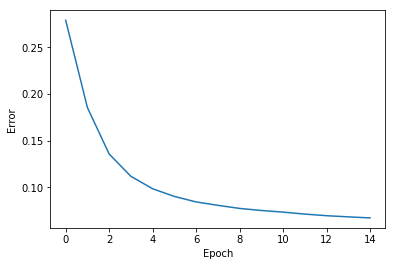

In [48]:
epochs = 15
batchsize = 100
errors = []
for i in range(epochs):
    for start, end in zip( range(0, len(trX), batchsize), range(batchsize, len(trX), batchsize)):
        batch = trX[start:end]
        cur_w = sess.run(update_w, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_vb = sess.run(update_vb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_nb = sess.run(update_hb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        prv_w = cur_w
        prv_vb = cur_vb
        prv_hb = cur_nb
    errors.append(sess.run(err_sum, feed_dict={v0: trX, W: cur_w, vb: cur_vb, hb: cur_nb}))
    print (errors[-1])
plt.plot(errors)
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.show()

In [ ]:
# We can now predict movies that an arbitrarily selected user might like.
# This can be accomplished by feeding in the user's watched movie 
# preferences into the RBM and then reconstructing the input. 

In [49]:
#Selecting the input user
inputUser = [trX[69]]

In [50]:
#Feeding in the user and reconstructing the input
hh0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W)) + vb)
feed = sess.run(hh0, feed_dict={ v0: inputUser, W: prv_w, hb: prv_hb})
rec = sess.run(vv1, feed_dict={ hh0: feed, W: prv_w, vb: prv_vb})

In [51]:
# We can then list the 20 most recommended movies for our mock
# user by sorting it by their scores given by our model.

In [53]:
scored_movies_df_69 = movies_df
scored_movies_df_69["Recommendation Score"] = rec[0]
scored_movies_df_69.sort_values(["Recommendation Score"], ascending=False).head(20)

,MovieID,Title,Genres,List Index,Recommendation Score
2789,2858,American Beauty (1999),Comedy|Drama,2789,0.585889
257,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi,257,0.573657
1192,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War,1192,0.479356
2502,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,2502,0.479192
585,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi|Thriller,585,0.474662
1178,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War,1178,0.472795
589,593,"Silence of the Lambs, The (1991)",Drama|Thriller,589,0.445047
1959,2028,Saving Private Ryan (1998),Action|Drama|War,1959,0.441696
108,110,Braveheart (1995),Action|Drama|War,108,0.434470
476,480,Jurassic Park (1993),Action|Adventure|Sci-Fi,476,0.415340


In [54]:
#TO recommend something the user has not yet watched


In [55]:
merged_df.iloc[69]

MovieID         1
List Index      0
UserID        195
Rating          5
Name: 69, dtype: int64

In [56]:
#Now, we can find all the movies that our mock user has watched before

In [57]:
movies_df_69 = merged_df[merged_df['UserID']==215]
movies_df_69.head()

,MovieID,List Index,UserID,Rating
75,1,0,215,4
11873,24,23,215,5
67543,260,257,215,5
82782,316,313,215,4
97063,356,352,215,5


In [58]:
# #In the next cell, we merge all the movies that our mock users has 
# watched with the predicted scors based on his historical data:

In [59]:
#Merging movies_df with ratings_df by MovieID
merged_df_69 = scored_movies_df_69.merge(movies_df_69, on='MovieID', how='outer')
#Dropping unecessary columns
merged_df_69 = merged_df_69.drop('List Index_y', axis=1).drop('UserID', axis=1)

In [62]:
merged_df_69.sort_values(["Recommendation Score"], ascending=False).head(20)

,MovieID,Title,Genres,List Index_x,Recommendation Score,Rating
2789,2858,American Beauty (1999),Comedy|Drama,2789,0.585889,NaN
257,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi,257,0.573657,5.0
1192,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War,1192,0.479356,5.0
2502,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,2502,0.479192,NaN
585,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi|Thriller,585,0.474662,NaN
1178,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War,1178,0.472795,NaN
589,593,"Silence of the Lambs, The (1991)",Drama|Thriller,589,0.445047,NaN
1959,2028,Saving Private Ryan (1998),Action|Drama|War,1959,0.441696,NaN
108,110,Braveheart (1995),Action|Drama|War,108,0.434470,NaN
476,480,Jurassic Park (1993),Action|Adventure|Sci-Fi,476,0.415340,5.0
